Signing suggestor, based on different approaches of the players stats. For each approach, you first should choose the team to suggest its top 5 new signings, following this list:

1. Arsenal
2. Aston Villa
3. Bournemouth
4. Brentford
5. Brighton
6. Chelsea
7. Crystal Palace
8. Everton
9. Fulham
10. Ipswich Town
11. Leicester City
12. Liverpool
13. Manchester City
14. Manchester Utd
15. Newcastle Utd
16. Nott'ham Forest
17. Southampton
18. Tottenham
19. West Ham
20. Wolves

Either the suggested signings and the "original" players have at least played 400 minutes this season

In [ ]:
import pandas as pd
from pathlib import Path
import numpy as np
 


data_dir = r'C:\SportsProject\premier_team_analysis\data'

player_stats_df = pd.read_csv(f'{data_dir}/player_stats.csv')
player_salaries_df = pd.read_csv(f'{data_dir}/player_salaries.csv')
team_stats_df = pd.read_csv(f'{data_dir}/team_stats.csv')
standings_df = pd.read_csv(f'{data_dir}/standings.csv')
fixtures_df = pd.read_csv(f'{data_dir}/fixtures.csv')
team_salary_df = pd.read_csv(f'{data_dir}/team_salary.csv')
player_possession_stats_df = pd.read_csv(f'{data_dir}/player_possession_stats.csv')
team_possession_stats_df = pd.read_csv(f'{data_dir}/team_possession_stats.csv')


#Code from https://www.kaggle.com/code/astonvaz/stats-don-t-lie-premier-league-24-25-deep-dive

df_dict = {
    'team_possession_stats': team_possession_stats_df,
    'player_possession_stats': player_possession_stats_df,
    'team_salary': team_salary_df,
    'standings': standings_df,
    'team_stats': team_stats_df,
    'player_salaries': player_salaries_df,
    'fixtures': fixtures_df,
    'player_stats': player_stats_df
}

def print_df_shape(name, dataframe):
    """Displays dataframe name and shape"""
    print(f"{name} Dataset shape: {dataframe.shape}\n")
    
def display_column_names(name, dataframe):
    """Displays column names in a dataframe"""
    print(f"{name} columns:\n{dataframe.columns.tolist()} \n")
    
def display_first_five_rows(table_name, dataframe):
    print(f"{table_name} data:")
    print(f"{dataframe.head(5)}\n\n")
    
def display_data_types(name, dataframe):
    print(f"{name} data types:")
    print(f"{dataframe.info()}\n")
    


KNN approach

Equips disponibles:
1. Arsenal
2. Aston Villa
3. Bournemouth
4. Brentford
5. Brighton
6. Chelsea
7. Crystal Palace
8. Everton
9. Fulham
10. Ipswich Town
11. Leicester City
12. Liverpool
13. Manchester City
14. Manchester Utd
15. Newcastle Utd
16. Nott'ham Forest
17. Southampton
18. Tottenham
19. West Ham
20. Wolves

Analitzant jugadors similars per a Brentford...

Top 10 fitxatges suggerits (per percentatge d'estalvi salarial):
Original Player Original Position  Original Age  Original Salary        Similar Player   Similar Team Similar Position  Similar Age  Similar Salary  Savings %
 Michael Kayode                DF          20.0     2.094226e+06            James Hill    Bournemouth               DF         23.0        317526.0  84.838026
Yehor Yarmoliuk                MF          21.0     5.021276e+06        Lucas Bergvall      Tottenham               MF         19.0        952577.0  81.029183
 Michael Kayode                DF          20.0     2.094226e+06       Yerson Mosquera     

c:\Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
c:\Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
c:\Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
c:\Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
c:\Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
c:\Project\.venv\Lib\site-packages\sklearn\utils\validation.py:27

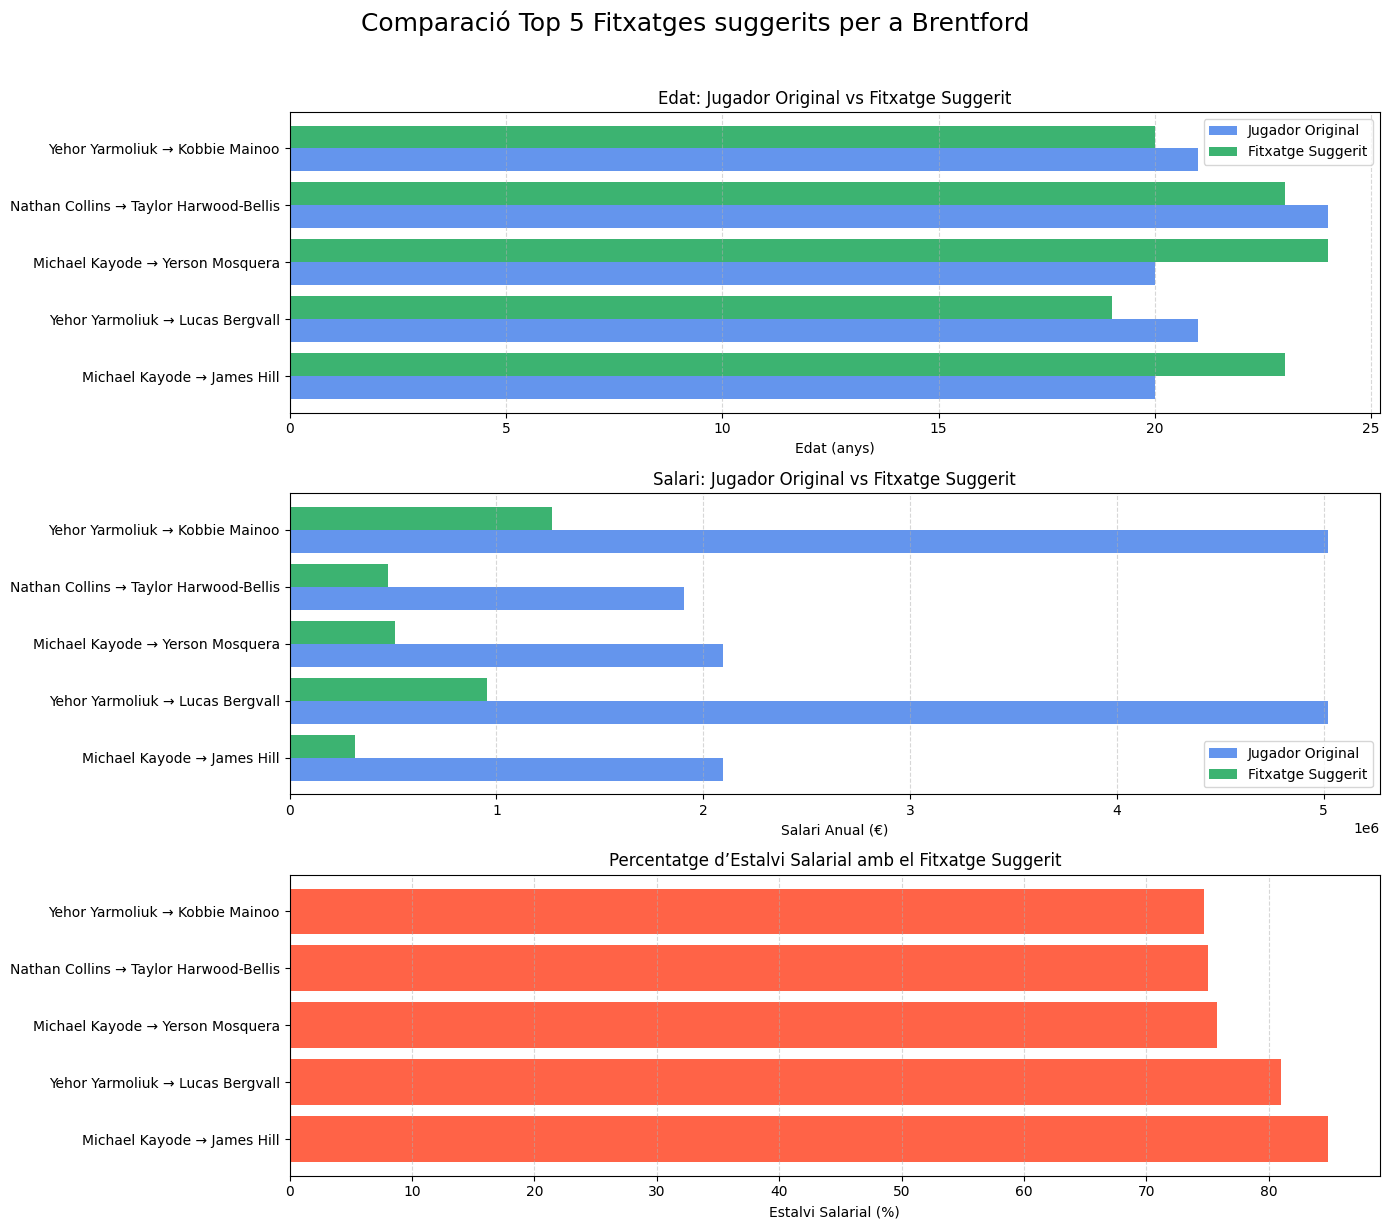

In [72]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

def load_and_merge_data(df_dict):
    player_stats = df_dict['player_stats']
    player_possession = df_dict['player_possession_stats']
    player_salaries = df_dict['player_salaries']

    for df in [player_stats, player_possession, player_salaries]:
        df.columns = df.columns.str.strip().str.lower()

    player_stats.rename(columns={'name': 'player'}, inplace=True)

    merged = player_stats.merge(player_possession, on=['player', 'team', 'age'], how='inner', suffixes=('', '_pos'))
    merged = merged.merge(player_salaries[['player', 'annual']], on='player', how='left')

    return merged

def select_features(df):
    # Agafa totes les columnes numèriques excloent identificadors i strings
    exclude_cols = ['player', 'team', 'position', 'nation', 'born']  # afegeix aquí altres strings si vols
    features = [col for col in df.columns if col not in exclude_cols and pd.api.types.is_numeric_dtype(df[col])]
    return features

def normalize(df, features):
    scaler = StandardScaler()
    df_scaled = df.copy()
    df_scaled[features] = scaler.fit_transform(df[features])
    return df_scaled, scaler

def find_similar_players(df, team_name, n_neighbors=5, salary_ratio=0.8, max_age_diff=2, min_minutes=400):
    df_copy = df.copy()

    # Filtra jugadors amb mínim minuts i reseteja l'índex perquè coincideixi el positional indexing
    df_copy = df_copy[df_copy['minutes'] >= min_minutes].reset_index(drop=True)

    features = select_features(df_copy)
    df_copy[features] = df_copy[features].fillna(df_copy[features].mean())
    df_norm, scaler = normalize(df_copy, features)

    team_players = df_norm[df_norm['team'] == team_name]
    others = df_norm[df_norm['team'] != team_name]

    if others.shape[0] == 0:
        print("No s'han trobat jugadors similars que compleixin els criteris.")
        return pd.DataFrame()

    nn = NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(others[features])

    recs = []
    for _, player in team_players.iterrows():
        dists, idxs = nn.kneighbors([player[features]])
        for i, idx in enumerate(idxs[0]):
            sim = others.iloc[idx]
            original = df_copy.iloc[player.name]
            sim_orig = df_copy.iloc[sim.name]  # Ara sim.name és un índex posicional correcte

            # Mateixa posició
            if sim_orig['position'] != original['position']:
                continue

            # Filtra per salari o edat més jove
            if sim_orig['annual'] < original['annual'] * salary_ratio or sim_orig['age'] < original['age'] - max_age_diff:
                recs.append({
                    'Original Player': original['player'],
                    'Original Position': original['position'],
                    'Original Age': original['age'],
                    'Original Salary': original['annual'],
                    'Similar Player': sim_orig['player'],
                    'Similar Team': sim_orig['team'],
                    'Similar Position': sim_orig['position'],
                    'Similar Age': sim_orig['age'],
                    'Similar Salary': sim_orig['annual'],
                    'Age Difference': original['age'] - sim_orig['age'],
                    'Salary Difference': original['annual'] - sim_orig['annual'],
                    'Distance': dists[0][i],
                })

    return pd.DataFrame(recs).sort_values('Distance') if recs else pd.DataFrame()

def compare_top5_pairs(df, team_name):
    if df.empty:
        print("No hi ha recomanacions per comparar.")
        return

    df['Savings %'] = df['Salary Difference'] / df['Original Salary'] * 100
    top5 = df.nlargest(5, 'Savings %').reset_index(drop=True)

    n = len(top5)
    y_pos = np.arange(n)

    labels = [f"{top5.loc[i, 'Original Player']} → {top5.loc[i, 'Similar Player']}" for i in range(n)]

    plt.figure(figsize=(14, 12))
    plt.suptitle(f'Comparació Top 5 Fitxatges suggerits per a {team_name}', fontsize=18, y=1.02)

    # Edat
    plt.subplot(3, 1, 1)
    plt.barh(y_pos - 0.2, top5['Original Age'], height=0.4, label='Jugador Original', color='cornflowerblue')
    plt.barh(y_pos + 0.2, top5['Similar Age'], height=0.4, label='Fitxatge Suggerit', color='mediumseagreen')
    plt.yticks(y_pos, labels)
    plt.xlabel('Edat (anys)')
    plt.title('Edat: Jugador Original vs Fitxatge Suggerit')
    plt.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    # Salari
    plt.subplot(3, 1, 2)
    plt.barh(y_pos - 0.2, top5['Original Salary'], height=0.4, label='Jugador Original', color='cornflowerblue')
    plt.barh(y_pos + 0.2, top5['Similar Salary'], height=0.4, label='Fitxatge Suggerit', color='mediumseagreen')
    plt.yticks(y_pos, labels)
    plt.xlabel('Salari Anual (€)')
    plt.title('Salari: Jugador Original vs Fitxatge Suggerit')
    plt.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    # Percentatge d’estalvi salarial
    plt.subplot(3, 1, 3)
    plt.barh(y_pos, top5['Savings %'], color='tomato')
    plt.yticks(y_pos, labels)
    plt.xlabel('Estalvi Salarial (%)')
    plt.title('Percentatge d’Estalvi Salarial amb el Fitxatge Suggerit')
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

def main(df_dict):
    merged = load_and_merge_data(df_dict)

    teams = sorted(merged['team'].unique())
    print("Equips disponibles:")
    for i, team in enumerate(teams, 1):
        print(f"{i}. {team}")

    try:
        sel = int(input("\nSelecciona el número de l'equip per analitzar (0 per sortir): "))
        if sel == 0:
            print("Sortint...")
            return
        selected_team = teams[sel - 1]
    except Exception:
        print("Entrada no vàlida.")
        return

    print(f"\nAnalitzant jugadors similars per a {selected_team}...")

    recommendations = find_similar_players(merged, selected_team, n_neighbors=10, min_minutes=400)

    if not recommendations.empty:
        recommendations['Savings %'] = recommendations['Salary Difference'] / recommendations['Original Salary'] * 100
        top10_savings = recommendations.nlargest(10, 'Savings %')

        print("\nTop 10 fitxatges suggerits (per percentatge d'estalvi salarial):")
        print(top10_savings[['Original Player', 'Original Position', 'Original Age', 'Original Salary',
                             'Similar Player', 'Similar Team', 'Similar Position', 'Similar Age',
                             'Similar Salary', 'Savings %']].to_string(index=False))

        compare_top5_pairs(recommendations, selected_team)

    else:
        print("No s'han trobat jugadors similars que compleixin els criteris.")


if __name__ == "__main__":
    import os

    data_dir = r'C:\Project\premier_team_analysis\data'

    df_dict = {
        'player_stats': pd.read_csv(os.path.join(data_dir, 'player_stats.csv')),
        'player_salaries': pd.read_csv(os.path.join(data_dir, 'player_salaries.csv')),
        'player_possession_stats': pd.read_csv(os.path.join(data_dir, 'player_possession_stats.csv')),
        'team_possession_stats': pd.read_csv(os.path.join(data_dir, 'team_possession_stats.csv'))
    }

    main(df_dict)


Kmeans approach

Available teams:
1. Arsenal
2. Aston Villa
3. Bournemouth
4. Brentford
5. Brighton
6. Chelsea
7. Crystal Palace
8. Everton
9. Fulham
10. Ipswich Town
11. Leicester City
12. Liverpool
13. Manchester City
14. Manchester Utd
15. Newcastle Utd
16. Nott'ham Forest
17. Southampton
18. Tottenham
19. West Ham
20. Wolves

Analyzing suggested replacements for Brentford using KMeans...
Players after filtering by minimum 400 minutes: 342

Top 10 Suggested Replacements (by salary savings percentage):
Original Player Original Position  Original Age  Original Salary        Similar Player   Similar Team Similar Position  Similar Age  Similar Salary  Savings %
 Michael Kayode                DF          20.0     2.094226e+06            James Hill    Bournemouth               DF         23.0        317526.0  84.838026
Yehor Yarmoliuk                MF          21.0     4.434847e+06        Lucas Bergvall      Tottenham               MF         19.0        952577.0  78.520635
 Michael Kayode               

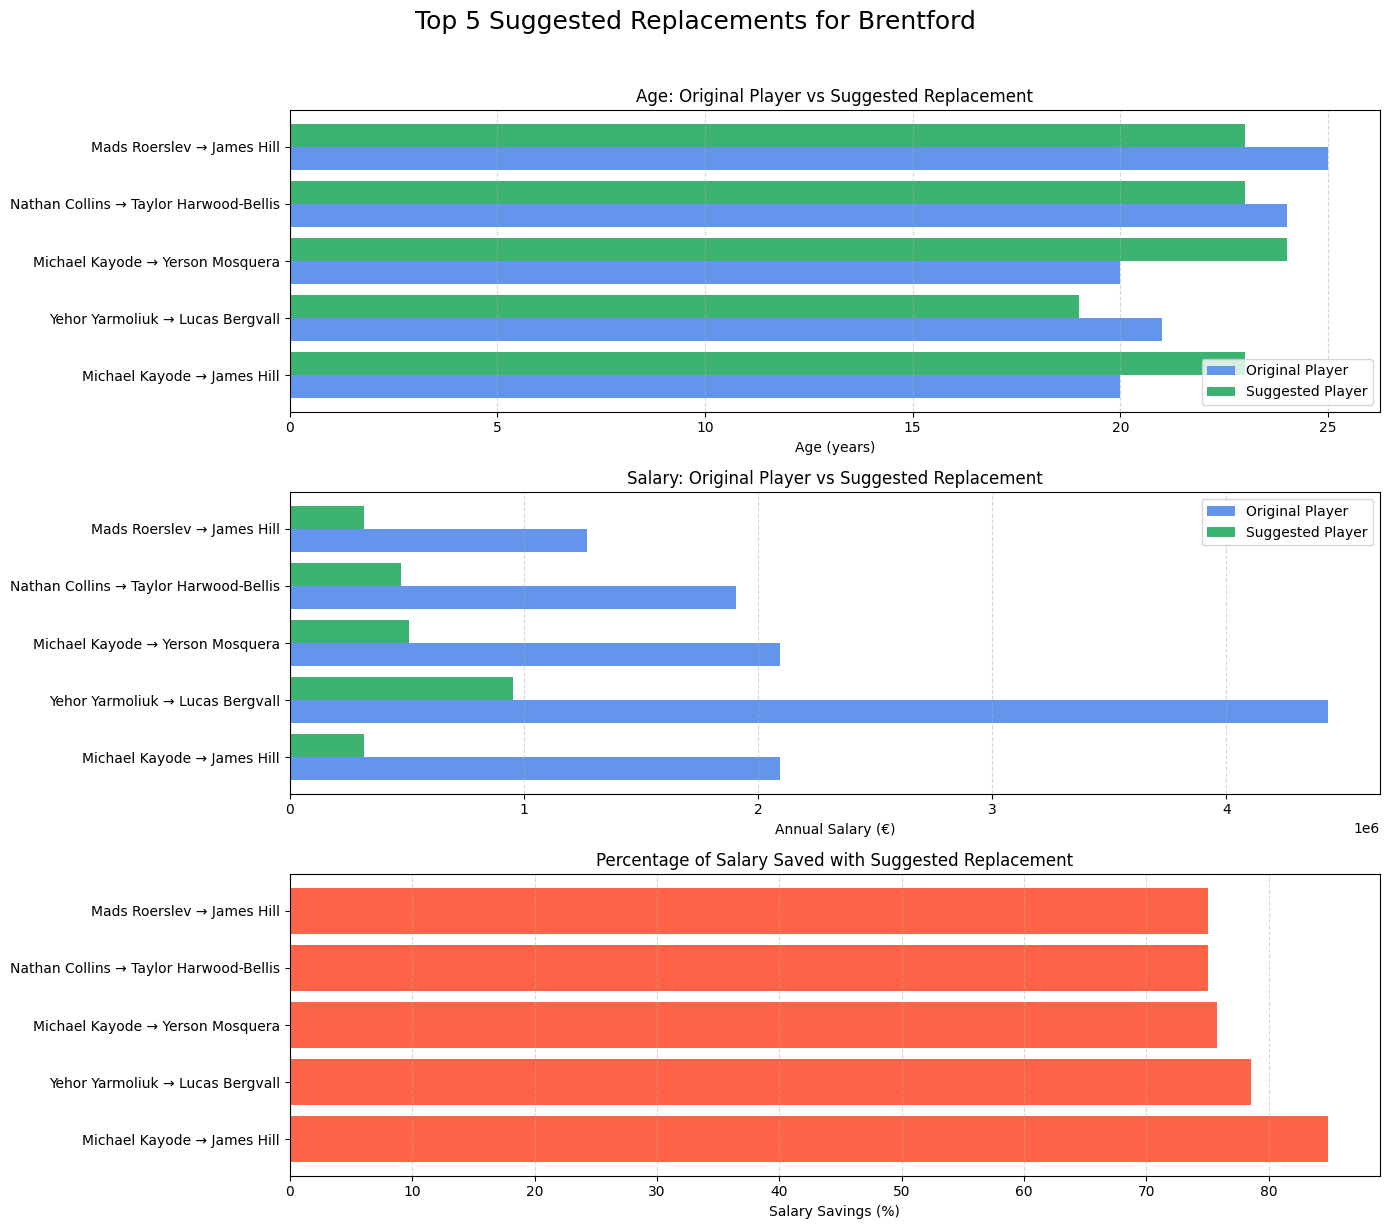

In [66]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def load_and_merge_data(df_dict):
    player_stats = df_dict['player_stats']
    player_possession = df_dict['player_possession_stats']
    player_salaries = df_dict['player_salaries']

    for df in [player_stats, player_possession, player_salaries]:
        df.columns = df.columns.str.strip().str.lower()

    player_stats.rename(columns={'name': 'player'}, inplace=True)

    merged = player_stats.merge(player_possession, on=['player', 'team', 'age'], how='inner', suffixes=('', '_pos'))
    merged = merged.merge(player_salaries[['player', 'annual']], on='player', how='left')

    return merged

def select_features(df):
    exclude_cols = ['player', 'team', 'position', 'nation', 'born']
    features = [col for col in df.columns if col not in exclude_cols and pd.api.types.is_numeric_dtype(df[col])]
    return features

def normalize(df, features):
    scaler = StandardScaler()
    df_scaled = df.copy()
    df_scaled[features] = scaler.fit_transform(df[features])
    return df_scaled, scaler

def kmeans_scouting(df, team_name, n_clusters=20, salary_ratio=0.8, max_age_diff=2, min_minutes=400):
    df_copy = df.copy()
    features = select_features(df_copy)
    df_copy[features] = df_copy[features].fillna(df_copy[features].mean())

    # Detect column for minutes played
    possible_min_cols = ['minutes', 'min', 'minutes_played', 'mins', 'playing_time']
    minutes_col = next((col for col in possible_min_cols if col in df_copy.columns), None)

    if minutes_col is None:
        print("No valid minutes played column found.")
        print("Available columns:", df_copy.columns.tolist())
        return pd.DataFrame()

    # Filter out players below minimum minutes played
    df_copy = df_copy[df_copy[minutes_col] >= min_minutes]
    print(f"Players after filtering by minimum {min_minutes} minutes: {len(df_copy)}")

    df_norm, scaler = normalize(df_copy, features)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df_norm['cluster'] = kmeans.fit_predict(df_norm[features])

    team_players = df_norm[df_norm['team'] == team_name]
    others = df_norm[df_norm['team'] != team_name]

    recs = []

    for _, player in team_players.iterrows():
        cluster_id = player['cluster']
        candidates = others[(others['cluster'] == cluster_id) & (others['position'] == player['position'])]

        for _, sim in candidates.iterrows():
            original = df_copy.loc[player.name]
            sim_orig = df_copy.loc[sim.name]

            if sim_orig['annual'] < original['annual'] * salary_ratio or sim_orig['age'] < original['age'] - max_age_diff:
                recs.append({
                    'Original Player': original['player'],
                    'Original Position': original['position'],
                    'Original Age': original['age'],
                    'Original Salary': original['annual'],
                    'Similar Player': sim_orig['player'],
                    'Similar Team': sim_orig['team'],
                    'Similar Position': sim_orig['position'],
                    'Similar Age': sim_orig['age'],
                    'Similar Salary': sim_orig['annual'],
                    'Age Difference': original['age'] - sim_orig['age'],
                    'Salary Difference': original['annual'] - sim_orig['annual'],
                    'Cluster': cluster_id
                })

    return pd.DataFrame(recs).sort_values(by='Salary Difference', ascending=False) if recs else pd.DataFrame()

def compare_top5_pairs(df, team_name):
    if df.empty:
        print("No recommendations available.")
        return

    df['Savings %'] = df['Salary Difference'] / df['Original Salary'] * 100
    top5 = df.nlargest(5, 'Savings %').reset_index(drop=True)

    n = len(top5)
    y_pos = np.arange(n)
    labels = [f"{top5.loc[i, 'Original Player']} → {top5.loc[i, 'Similar Player']}" for i in range(n)]

    plt.figure(figsize=(14, 12))
    plt.suptitle(f'Top 5 Suggested Replacements for {team_name}', fontsize=18, y=1.02)

    # Age Comparison
    plt.subplot(3, 1, 1)
    plt.barh(y_pos - 0.2, top5['Original Age'], height=0.4, label='Original Player', color='cornflowerblue')
    plt.barh(y_pos + 0.2, top5['Similar Age'], height=0.4, label='Suggested Player', color='mediumseagreen')
    plt.yticks(y_pos, labels)
    plt.xlabel('Age (years)')
    plt.title('Age: Original Player vs Suggested Replacement')
    plt.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    # Salary Comparison
    plt.subplot(3, 1, 2)
    plt.barh(y_pos - 0.2, top5['Original Salary'], height=0.4, label='Original Player', color='cornflowerblue')
    plt.barh(y_pos + 0.2, top5['Similar Salary'], height=0.4, label='Suggested Player', color='mediumseagreen')
    plt.yticks(y_pos, labels)
    plt.xlabel('Annual Salary (€)')
    plt.title('Salary: Original Player vs Suggested Replacement')
    plt.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    # Salary Savings
    plt.subplot(3, 1, 3)
    plt.barh(y_pos, top5['Savings %'], color='tomato')
    plt.yticks(y_pos, labels)
    plt.xlabel('Salary Savings (%)')
    plt.title('Percentage of Salary Saved with Suggested Replacement')
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

def main(df_dict):
    merged = load_and_merge_data(df_dict)

    teams = sorted(merged['team'].unique())
    print("Available teams:")
    for i, team in enumerate(teams, 1):
        print(f"{i}. {team}")

    try:
        sel = int(input("\nSelect a team by number (0 to exit): "))
        if sel == 0:
            print("Exiting...")
            return
        selected_team = teams[sel - 1]
    except Exception:
        print("Invalid input.")
        return

    print(f"\nAnalyzing suggested replacements for {selected_team} using KMeans...")

    recommendations = kmeans_scouting(merged, selected_team, n_clusters=20, min_minutes=400)

    if not recommendations.empty:
        recommendations['Savings %'] = recommendations['Salary Difference'] / recommendations['Original Salary'] * 100
        top10_savings = recommendations.nlargest(10, 'Savings %')

        print("\nTop 10 Suggested Replacements (by salary savings percentage):")
        print(top10_savings[['Original Player', 'Original Position', 'Original Age', 'Original Salary',
                             'Similar Player', 'Similar Team', 'Similar Position', 'Similar Age',
                             'Similar Salary', 'Savings %']].to_string(index=False))

        compare_top5_pairs(recommendations, selected_team)
    else:
        print("No suitable replacements found based on the criteria.")

if __name__ == "__main__":
    import os
    data_dir = r'C:\Project\premier_team_analysis\data'
    df_dict = {
        'player_stats': pd.read_csv(os.path.join(data_dir, 'player_stats.csv')),
        'player_salaries': pd.read_csv(os.path.join(data_dir, 'player_salaries.csv')),
        'player_possession_stats': pd.read_csv(os.path.join(data_dir, 'player_possession_stats.csv')),
        'team_possession_stats': pd.read_csv(os.path.join(data_dir, 'team_possession_stats.csv'))
    }

    main(df_dict)


Logistic regression approach (Random Forest)

Available teams:
1. Arsenal
2. Aston Villa
3. Bournemouth
4. Brentford
5. Brighton
6. Chelsea
7. Crystal Palace
8. Everton
9. Fulham
10. Ipswich Town
11. Leicester City
12. Liverpool
13. Manchester City
14. Manchester Utd
15. Newcastle Utd
16. Nott'ham Forest
17. Southampton
18. Tottenham
19. West Ham
20. Wolves

Training salary prediction model...
Salary prediction R^2 score on test set: 1.000

Finding similar players to those in Brentford based on predicted salary...

Top 10 suggested transfers (by percentage salary savings):
 Original Player Original Position  Original Age  Original Predicted Salary     Similar Player   Similar Team Similar Position  Similar Age  Similar Predicted Salary  Savings %
Mikkel Damsgaard             MF,FW          24.0                 1903687.50   Omari Hutchinson   Ipswich Town            MF,FW         21.0                 376760.28  80.208922
Mikkel Damsgaard             MF,FW          24.0                 1903687.50   Nathan Broadhead   Ipswich Town   

C:\Users\Sergi Trilla\AppData\Local\Temp\ipykernel_39212\2100499895.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  others['distance'] = np.abs(others['predicted_salary'] - player['predicted_salary'])
C:\Users\Sergi Trilla\AppData\Local\Temp\ipykernel_39212\2100499895.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  others['distance'] = np.abs(others['predicted_salary'] - player['predicted_salary'])
C:\Users\Sergi Trilla\AppData\Local\Temp\ipykernel_39212\2100499895.py:72: SettingWithCopyWarning: 


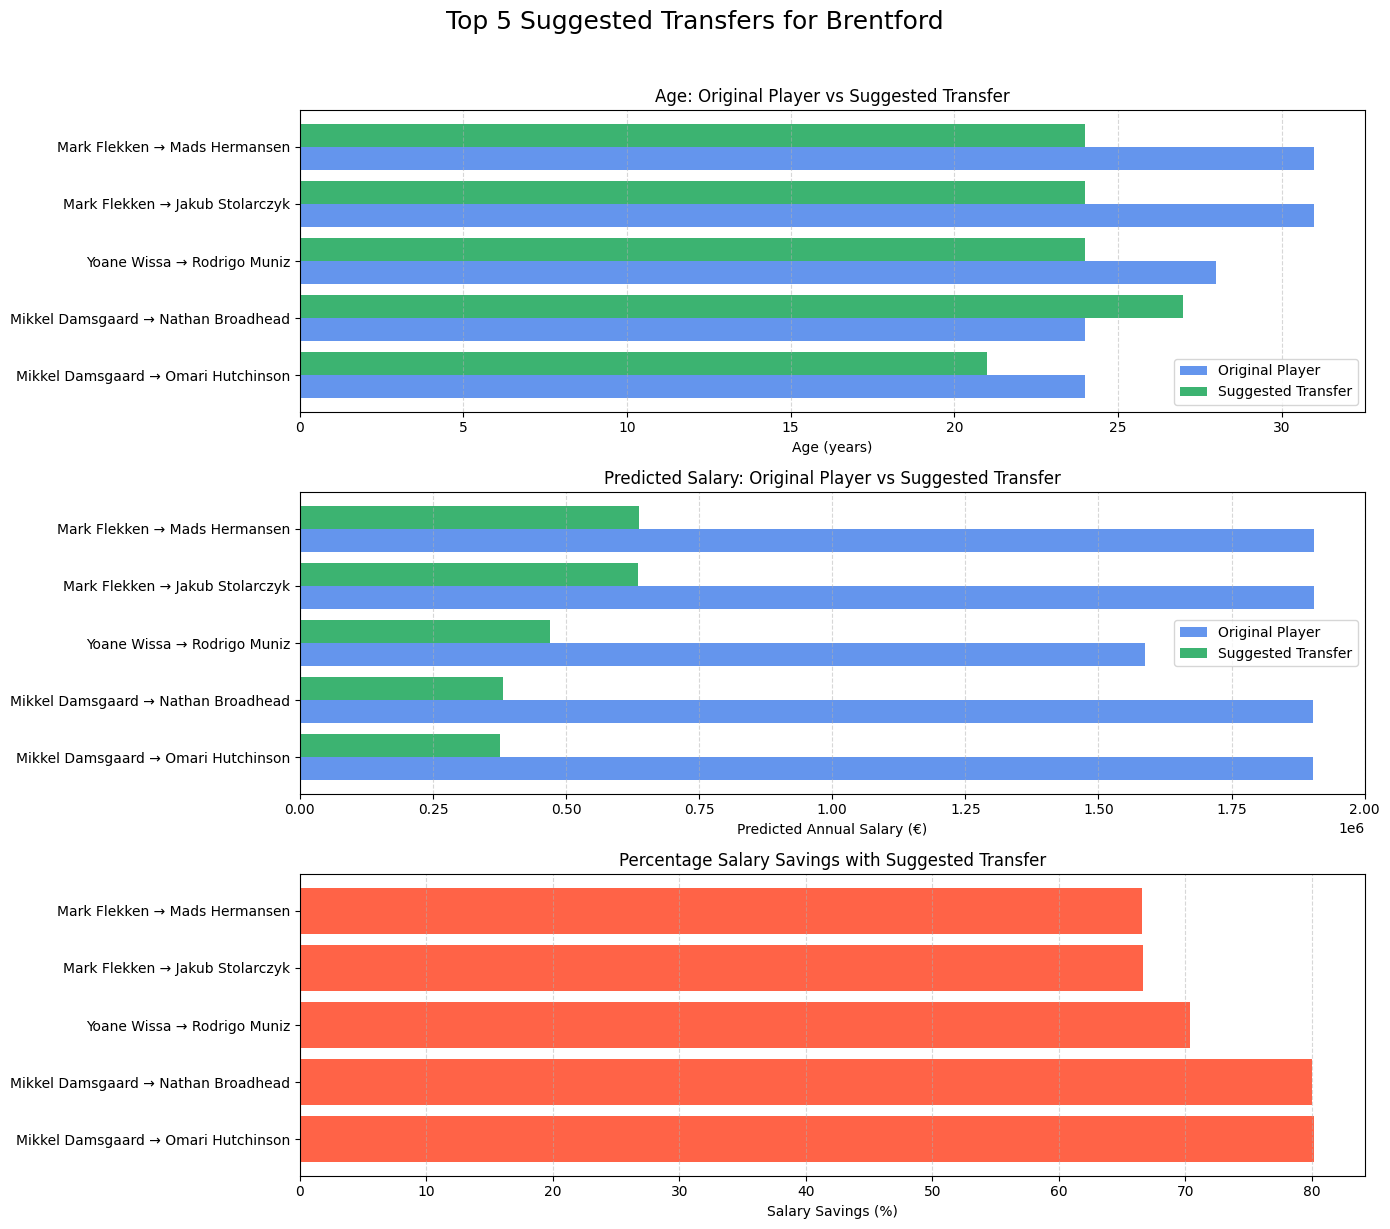

In [74]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def load_and_merge_data(df_dict):
    player_stats = df_dict['player_stats']
    player_possession = df_dict['player_possession_stats']
    player_salaries = df_dict['player_salaries']

    for df in [player_stats, player_possession, player_salaries]:
        df.columns = df.columns.str.strip().str.lower()

    player_stats.rename(columns={'name': 'player'}, inplace=True)

    merged = player_stats.merge(player_possession, on=['player', 'team', 'age'], how='inner', suffixes=('', '_pos'))
    merged = merged.merge(player_salaries[['player', 'annual']], on='player', how='left')

    return merged

def select_features(df):
    # Select numeric columns excluding identifiers and strings
    exclude_cols = ['player', 'team', 'position', 'nation', 'born']
    features = [col for col in df.columns if col not in exclude_cols and pd.api.types.is_numeric_dtype(df[col])]
    return features

def normalize(df, features):
    scaler = StandardScaler()
    df_scaled = df.copy()
    df_scaled[features] = scaler.fit_transform(df[features])
    return df_scaled, scaler

def train_salary_predictor(df):
    # Drop rows without salary data
    df = df.dropna(subset=['annual'])
    features = select_features(df)
    df = df.copy()
    df[features] = df[features].fillna(df[features].mean())

    X = df[features]
    y = df['annual']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    score = model.score(X_test, y_test)
    print(f"Salary prediction R^2 score on test set: {score:.3f}")

    return model, features

def find_similar_by_predicted_salary(df, team_name, model, features, n_similar=5, min_minutes=400):
    df_copy = df.copy()
    df_copy = df_copy[df_copy['minutes'] >= min_minutes]

    # Prepare features for prediction
    df_copy[features] = df_copy[features].fillna(df_copy[features].mean())

    # Predict salary
    df_copy['predicted_salary'] = model.predict(df_copy[features])

    team_players = df_copy[df_copy['team'] == team_name]
    others = df_copy[df_copy['team'] != team_name]

    recs = []
    for _, player in team_players.iterrows():
        # Calculate Euclidean distances between predicted salary and others
        others['distance'] = np.abs(others['predicted_salary'] - player['predicted_salary'])

        # Filter for same position
        same_position = others[others['position'] == player['position']]

        # Sort by distance and pick top n_similar
        similar_players = same_position.nsmallest(n_similar, 'distance')

        for _, sim in similar_players.iterrows():
            # Filter criteria: lower predicted salary or younger by up to 2 years
            if sim['predicted_salary'] < player['predicted_salary'] * 0.8 or sim['age'] < player['age'] - 2:
                recs.append({
                    'Original Player': player['player'],
                    'Original Position': player['position'],
                    'Original Age': player['age'],
                    'Original Predicted Salary': player['predicted_salary'],
                    'Similar Player': sim['player'],
                    'Similar Team': sim['team'],
                    'Similar Position': sim['position'],
                    'Similar Age': sim['age'],
                    'Similar Predicted Salary': sim['predicted_salary'],
                    'Age Difference': player['age'] - sim['age'],
                    'Salary Difference': player['predicted_salary'] - sim['predicted_salary'],
                    'Distance': abs(player['predicted_salary'] - sim['predicted_salary']),
                })

    return pd.DataFrame(recs).sort_values('Distance') if recs else pd.DataFrame()

def compare_top5_pairs(df, team_name):
    if df.empty:
        print("No recommendations to compare.")
        return

    df['Savings %'] = df['Salary Difference'] / df['Original Predicted Salary'] * 100
    top5 = df.nlargest(5, 'Savings %').reset_index(drop=True)

    n = len(top5)
    y_pos = np.arange(n)

    labels = [f"{top5.loc[i, 'Original Player']} → {top5.loc[i, 'Similar Player']}" for i in range(n)]

    plt.figure(figsize=(14, 12))
    plt.suptitle(f'Top 5 Suggested Transfers for {team_name}', fontsize=18, y=1.02)

    # Age comparison
    plt.subplot(3, 1, 1)
    plt.barh(y_pos - 0.2, top5['Original Age'], height=0.4, label='Original Player', color='cornflowerblue')
    plt.barh(y_pos + 0.2, top5['Similar Age'], height=0.4, label='Suggested Transfer', color='mediumseagreen')
    plt.yticks(y_pos, labels)
    plt.xlabel('Age (years)')
    plt.title('Age: Original Player vs Suggested Transfer')
    plt.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    # Predicted salary comparison
    plt.subplot(3, 1, 2)
    plt.barh(y_pos - 0.2, top5['Original Predicted Salary'], height=0.4, label='Original Player', color='cornflowerblue')
    plt.barh(y_pos + 0.2, top5['Similar Predicted Salary'], height=0.4, label='Suggested Transfer', color='mediumseagreen')
    plt.yticks(y_pos, labels)
    plt.xlabel('Predicted Annual Salary (€)')
    plt.title('Predicted Salary: Original Player vs Suggested Transfer')
    plt.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    # Savings percentage
    plt.subplot(3, 1, 3)
    plt.barh(y_pos, top5['Savings %'], color='tomato')
    plt.yticks(y_pos, labels)
    plt.xlabel('Salary Savings (%)')
    plt.title('Percentage Salary Savings with Suggested Transfer')
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

def main(df_dict):
    merged = load_and_merge_data(df_dict)

    teams = sorted(merged['team'].unique())
    print("Available teams:")
    for i, team in enumerate(teams, 1):
        print(f"{i}. {team}")

    try:
        sel = int(input("\nSelect the number of the team to analyze (0 to exit): "))
        if sel == 0:
            print("Exiting...")
            return
        selected_team = teams[sel - 1]
    except Exception:
        print("Invalid input.")
        return

    print(f"\nTraining salary prediction model...")
    model, features = train_salary_predictor(merged)

    print(f"\nFinding similar players to those in {selected_team} based on predicted salary...")
    recommendations = find_similar_by_predicted_salary(merged, selected_team, model, features, n_similar=10, min_minutes=400)

    if not recommendations.empty:
        recommendations['Savings %'] = recommendations['Salary Difference'] / recommendations['Original Predicted Salary'] * 100
        top10_savings = recommendations.nlargest(10, 'Savings %')

        print("\nTop 10 suggested transfers (by percentage salary savings):")
        print(top10_savings[['Original Player', 'Original Position', 'Original Age', 'Original Predicted Salary',
                             'Similar Player', 'Similar Team', 'Similar Position', 'Similar Age',
                             'Similar Predicted Salary', 'Savings %']].to_string(index=False))

        compare_top5_pairs(recommendations, selected_team)

    else:
        print("No similar players found that meet the criteria.")

if __name__ == "__main__":
    import os

    data_dir = r'C:\Project\premier_team_analysis\data'

    df_dict = {
        'player_stats': pd.read_csv(os.path.join(data_dir, 'player_stats.csv')),
        'player_salaries': pd.read_csv(os.path.join(data_dir, 'player_salaries.csv')),
        'player_possession_stats': pd.read_csv(os.path.join(data_dir, 'player_possession_stats.csv')),
        'team_possession_stats': pd.read_csv(os.path.join(data_dir, 'team_possession_stats.csv'))
    }

    main(df_dict)
